In [56]:
## import the tensorflow APIs
import tensorflow as tf
import pandas as pd
import math
import random
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

In [57]:
data_sitcoms = pd.read_csv("mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    1202 non-null   object 
 1   label   1202 non-null   float64
dtypes: float64(1), object(1)
memory usage: 18.9+ KB


In [59]:
train_sentences = data_sitcoms["text"]
##train_sentences

In [60]:
##instantiate the tokenizer
tokenizer = Tokenizer(num_words=100)

##train the tokenizer on training sentences
tokenizer.fit_on_texts(train_sentences)

##store word index for the words in the sentence
word_index = tokenizer.word_index
##print(word_index)

In [61]:
##create sequences using tokenizer
sequences = tokenizer.texts_to_sequences(train_sentences)

In [62]:
##print word index dictionary and sequences
##print(f"Word index -->{word_index}")
##print(f"Sequences of words -->{sequences}")

In [63]:
##print sample sentence and sequence
train_sentences = train_sentences.to_numpy()

In [64]:
print(train_sentences[random.randint(0,100)])
print(sequences[0])

No need to. As soon as she flies into California airspace, I'll feel a disturbance in the Force.
[6, 8, 50, 24, 1, 4]


In [65]:
##set up the tokenizer again with oov_token
tokenizer = Tokenizer(num_words=100, oov_token = "<oov>")

##train the new tokenizer on training sentences
tokenizer.fit_on_texts(train_sentences)

##store word index for the words in the sentence
word_index = tokenizer.word_index

In [66]:
##pad sequences
padded_seqs = pad_sequences(sequences)

In [67]:
##print(word_index)
##print(train_sentences)
##print(sequences)
##print(padded_seqs)

In [68]:
##pad sequences with padding type, max length and truncating parameters
padded_seqs = pad_sequences(sequences,
                            padding="post",
                            maxlen=5,
                            truncating="post",
                            )
print(padded_seqs)

[[ 6  8 50 24  1]
 [ 3 29 59 27  1]
 [23  7 17 58  0]
 ...
 [31 72 89 67 42]
 [ 2  9 16  3  0]
 [ 9 42 57  0  0]]


In [69]:
##create empty list to store sentences and labels
train_sentences = []
test_sentences = []

train_labels = []
test_labels = []

In [70]:
#create size variables to for training
subset_size = len(data_sitcoms.index)
testing_size = int(subset_size * 0.2)
validation_size = testing_size
shuffle_size = subset_size - validation_size

In [71]:
data = data_sitcoms.sample(frac=1).reset_index(drop=True)
train_data = data.head(subset_size - testing_size)
test_data = data.tail(testing_size)

In [72]:
for sentence in train_data['text']:
    train_sentences.append(sentence)
for sentence in test_data['text']:
    test_sentences.append(sentence)

In [73]:
for value in train_data['label']:
    train_labels.append(value)
for value in test_data['label']:
    test_labels.append(value)

In [74]:
##convert lists into numpy array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [75]:
##define the parameters for the tokenizing and padding
vocab_size = 10000
embedding_dim = 16
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [76]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seqs,maxlen=max_length, padding=padding_type, truncating=trunc_type)

##testing sequences and labels
test_seqs = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seqs,maxlen=max_length)

In [77]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(train_sentences[1])
print(train_padded[1])
print(decode_review(train_padded[1]))

And when I was little and my dog died, my mom sat me down and very gently told me that she wished the truck had hit my dad instead.
[  7  69   3  15  75   7  13 266 517  13 206 829  18 113   7 134]
and when i was little and my dog died my mom sat me down and very


Define the Neural Network with Embedding layer

In [78]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##compile the model with loss function, optimizer and metrics
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 16)            160000    
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 1542      
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 161,549
Trainable params: 161,549
Non-trainable params: 0
_________________________________________________________________


Model Training

In [79]:
num_epochs = 10

##train the model with training and validation set
model.fit(
    train_padded, 
    train_labels, 
    epochs=num_epochs, 
    validation_data=(test_padded, test_labels)
    )

Epoch 1/10
31/31 [==============================] - 1s 10ms/step - loss: 0.6927 - accuracy: 0.5405 - val_loss: 0.6918 - val_accuracy: 0.5375
Epoch 2/10
31/31 [==============================] - 0s 7ms/step - loss: 0.6846 - accuracy: 0.7089 - val_loss: 0.6897 - val_accuracy: 0.5375
Epoch 3/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6691 - accuracy: 0.7516 - val_loss: 0.6882 - val_accuracy: 0.5417
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6392 - accuracy: 0.8243 - val_loss: 0.6887 - val_accuracy: 0.5375
Epoch 5/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5836 - accuracy: 0.8742 - val_loss: 0.6929 - val_accuracy: 0.5125
Epoch 6/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5053 - accuracy: 0.9054 - val_loss: 0.7066 - val_accuracy: 0.5208
Epoch 7/10
31/31 [==============================] - 0s 6ms/step - loss: 0.4109 - accuracy: 0.9293 - val_loss: 0.7287 - val_accuracy: 0.5167
Epoch 8/10
31/31 [=

Derive weights from the embedding layer

In [80]:
##isolating the first embedding layer
l1 = model.layers[0]

##extracting learned weights
weights = l1.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
print(weights[0])

(10000, 16)
[-0.01447751 -0.07139269  0.09716782 -0.10963321 -0.06819431  0.08803178
  0.03952713  0.17094028  0.17576338 -0.09175452  0.11301392 -0.07946059
  0.0138609  -0.05985145 -0.05317088 -0.12996913]


Download the vectors and metadata

In [81]:
##import I/O module in python
import io

##open the text stream for vectors
vectors = io.open('vectors.tsv', 'w', encoding='utf-8')

##open the text stream for metadata
meta = io.open('meta.tsv', 'w', encoding='utf-8')

##write each word and its corresponding embedding
for index in range(len(reverse_word_index)):
  word = reverse_word_index.get(index)  # flipping the key-value in word_index
  embeddings = weights[index]
  if word is None:
    break
  else:
    meta.write(word + "\n")
    vectors.write('\t'.join([str(x) for x in embeddings]) + "\n")

##close the stream
vectors.close()
meta.close()

In [82]:
##download the written files to your local machine
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vectors.tsv')
  files.download('meta.tsv')

In [83]:
##define tokenizing and padding parameters
vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 700

In [84]:
##store headlines and labels in respective lists
sentences = list(data['text'])
labels = list(data['label'])

In [86]:
##sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

##labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [87]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [88]:
# convert lists into numpy arrays to make it work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [91]:
num_epochs = 30
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Epoch 1/30
22/22 - 1s - loss: 0.6932 - accuracy: 0.5143 - val_loss: 0.6940 - val_accuracy: 0.4761 - 688ms/epoch - 31ms/step
Epoch 2/30
22/22 - 0s - loss: 0.6927 - accuracy: 0.5171 - val_loss: 0.6948 - val_accuracy: 0.4761 - 173ms/epoch - 8ms/step
Epoch 3/30
22/22 - 0s - loss: 0.6924 - accuracy: 0.5171 - val_loss: 0.6943 - val_accuracy: 0.4761 - 167ms/epoch - 8ms/step
Epoch 4/30
22/22 - 0s - loss: 0.6920 - accuracy: 0.5171 - val_loss: 0.6954 - val_accuracy: 0.4761 - 156ms/epoch - 7ms/step
Epoch 5/30
22/22 - 0s - loss: 0.6915 - accuracy: 0.5171 - val_loss: 0.6949 - val_accuracy: 0.4761 - 149ms/epoch - 7ms/step
Epoch 6/30
22/22 - 0s - loss: 0.6909 - accuracy: 0.5171 - val_loss: 0.6952 - val_accuracy: 0.4761 - 150ms/epoch - 7ms/step
Epoch 7/30
22/22 - 0s - loss: 0.6902 - accuracy: 0.5171 - val_loss: 0.6943 - val_accuracy: 0.4761 - 146ms/epoch - 7ms/step
Epoch 8/30
22/22 - 0s - loss: 0.6893 - accuracy: 0.5186 - val_loss: 0.6940 - val_accuracy: 0.4761 - 139ms/epoch - 6ms/step
Epoch 9/30
22/2

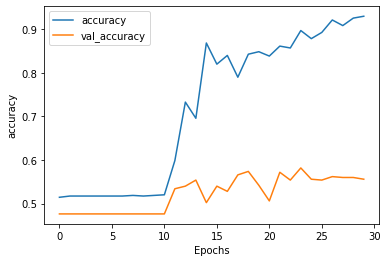

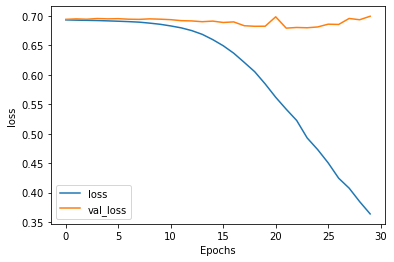

In [92]:
import matplotlib.pyplot as plt

##plot the scores from history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.legend([string, 'val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")